Importing libraries

In [2]:
import matplotlib.pylab as plt
from tqdm import tqdm
import matplotlib.colors as pltc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

Importing the data from Gdrive

In [1]:
from google.colab import drive
# Montez Google Drive
drive.mount('/content/drive')
!cp -r "/content/drive/My Drive/Land_Cover/" "/content/Land_Cover/"


Mounted at /content/drive


Splitting the data in small images

In [45]:
import glob
import os
import cv2

def split(do_split=False) :
  if not do_split :
    return
  IMGS_DIR = "./data/images"
  MASKS_DIR = "./data/masks"
  OUTPUT_DIR = "./data/output"
  OUTPUT_MASKS_DIR = "./data/output/masks"
  OUTPUT_IMAGES_DIR = "./data/output/images"

  TARGET_SIZE = 512

  img_paths = glob.glob(os.path.join(IMGS_DIR, "*.tif"))
  mask_paths = glob.glob(os.path.join(MASKS_DIR, "*.tif"))

  img_paths.sort()
  mask_paths.sort()

  os.makedirs(OUTPUT_DIR)
  os.makedirs(OUTPUT_MASKS_DIR)
  os.makedirs(OUTPUT_IMAGES_DIR)
  for i, (img_path, mask_path) in tqdm(enumerate(zip(img_paths, mask_paths))):
      img_filename = os.path.splitext(os.path.basename(img_path))[0]
      mask_filename = os.path.splitext(os.path.basename(mask_path))[0]
      img = cv2.imread(img_path)
      mask = cv2.imread(mask_path)

      assert img_filename == mask_filename and img.shape[:2] == mask.shape[:2]

      k = 0
      for y in range(0, img.shape[0], TARGET_SIZE):
          for x in range(0, img.shape[1], TARGET_SIZE):
              img_tile = img[y:y + TARGET_SIZE, x:x + TARGET_SIZE]
              mask_tile = mask[y:y + TARGET_SIZE, x:x + TARGET_SIZE, 0]

              if img_tile.shape[0] == TARGET_SIZE and img_tile.shape[1] == TARGET_SIZE:
                  out_img_path = os.path.join(OUTPUT_IMAGES_DIR, "{}_{}.tif".format(img_filename, k))
                  cv2.imwrite(out_img_path, img_tile)

                  out_mask_path = os.path.join(OUTPUT_MASKS_DIR, "{}_{}.tif".format(mask_filename, k))
                  cv2.imwrite(out_mask_path, mask_tile)

              k += 1
  return

split(do_split=True)

0it [00:00, ?it/s]

41it [04:17,  6.28s/it]


Opening an image

############# about the image ################
Shape: (512, 512, 3)


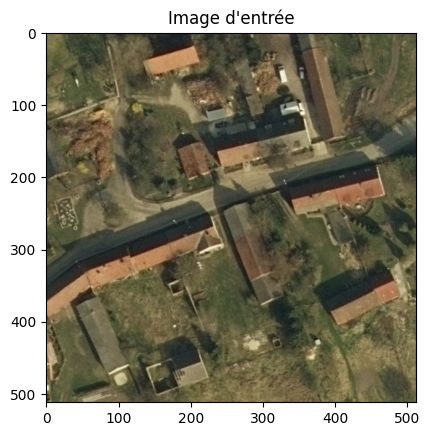



############# about the label ################
Shape: (512, 512)


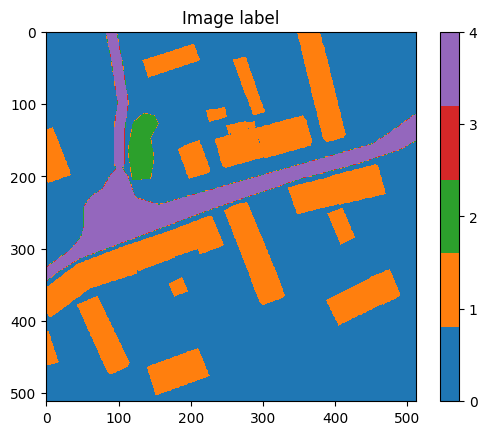

In [47]:
img_path = 'data/output/images/M-33-7-A-d-3-2_59.tif'
lbl_path = 'data/output/masks/M-33-7-A-d-3-2_59.tif'

print('############# about the image ################')
img_array = plt.imread(img_path)
print('Shape:', img_array.shape)
# Affichez l'image
plt.imshow(img_array)  # Vous pouvez ajuster la colormap en fonction de votre image
plt.title("Image d'entrée")
plt.show()
print('\n')

print('############# about the label ################')
lbl_array = plt.imread(lbl_path)
print('Shape:', lbl_array.shape)
# Affichez l'image
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
cmap = pltc.ListedColormap(colors)
plt.imshow(lbl_array, cmap=cmap, vmin=0, vmax=4)  # Vous pouvez ajuster la colormap en fonction de votre image
plt.title("Image label")
plt.colorbar(ticks=[0, 1, 2, 3, 4])
plt.show()

Setting global variables

In [51]:
# Dimensions de l'image en entrée et du nombre de classes
input_channels = 3  # 3 canaux pour une image RGB
output_channels = 5  # ajustez en fonction du nombre de classes de couvert terrestre que vous avez

def train_1_image(Unet, epochs):
    unet_model = Unet(input_channels, output_channels)

    # Définir la fonction de perte et l'optimiseur
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(unet_model.parameters(), lr=0.001)

    # Charger les images
    input_data = torch.from_numpy(img_array).float()
    label_data = torch.from_numpy(lbl_array).long()
    label_data = F.one_hot(label_data, num_classes=output_channels).unsqueeze(0).permute(0, 3, 1, 2).float()
    input_data = input_data.unsqueeze(0).permute(0, 3, 1, 2)
    print("input_data shape:",input_data.shape)
    print("label_data shape:",label_data.shape)

    for epoch in tqdm(range(epochs)):
        # Forward pass
        outputs = unet_model(input_data)

        # Appliquer la fonction softmax pour obtenir des probabilités
        probs = F.softmax(outputs, dim=1)

        # Obtenir la classe prédite pour chaque pixel
        _, predicted_class = torch.max(probs, dim=1)

        # Créer une image one-hot encoding à partir des classes prédites
        predicted_one_hot = F.one_hot(predicted_class, num_classes=output_channels)

        # Calcul de la perte
        loss = criterion(outputs, label_data)

        # Rétropropagation et mise à jour des poids
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return outputs

def show_results_1_image(outputs, lbl_array):
  print('############# result of the model ################')
  probs = F.softmax(outputs, dim=1)
  _, predicted_class = torch.max(probs, dim=1)
  # Convertir Tensor en NumPy array pour faciliter la manipulation
  predicted_class_np = predicted_class.cpu().numpy()
  colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
  cmap = pltc.ListedColormap(colors)
  # Affichez l'image
  plt.imshow(predicted_class_np[0], cmap=cmap, vmin=0, vmax=4)  # Vous pouvez ajuster la colormap en fonction de votre image
  plt.colorbar(ticks=[0, 1, 2, 3, 4])
  plt.title("Labeled image by the model")
  plt.show()
  print('\n')

  print('############# true label ################')
  lbl_array = plt.imread(lbl_path)
  # Affichez l'image
  colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
  cmap = pltc.ListedColormap(colors)
  plt.imshow(lbl_array, cmap=cmap, vmin=0, vmax=4)  # Vous pouvez ajuster la colormap en fonction de votre image
  plt.title("True labels")
  plt.colorbar(ticks=[0, 1, 2, 3, 4])
  plt.show()

## First model: Wrong Unet (With interpolation)

In [43]:
class UNet1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet1, self).__init__()

        # Encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Training of the model 1


In [44]:
outputs1 = train_1_image(UNet1, 10)

AttributeError: module 'torch.nn' has no attribute 'BinaryCrossEntropyLoss'

Test of the trained model

############# result of the model ################


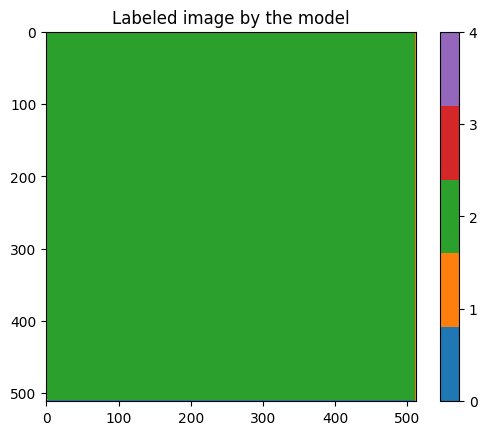



############# true label ################


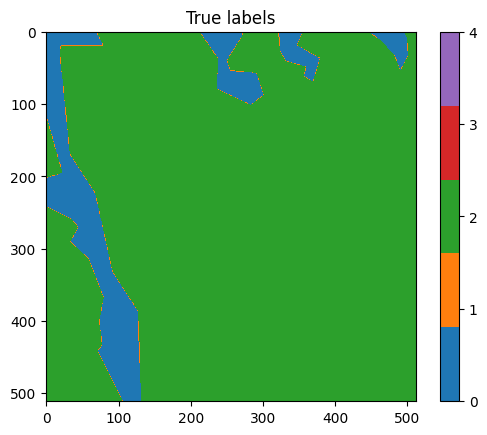

In [41]:
show_results_1_image(outputs1, lbl_array)

## Second model: Real Unet

![unet](https://pytorch.org/assets/images/unet_brain_mri.png)

In [49]:
class UNet2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet2, self).__init__()

        # Encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Bottleneck (no pooling in the middle)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Décodeur
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        # Encodeur
        x1 = self.encoder(x)

        # Bottleneck
        x2 = self.bottleneck(x1)

        # Décodeur avec skip connection
        x3 = self.decoder(x2)

        return x3

In [52]:
outputs2 = train_1_image(UNet2,100)

input_data shape: torch.Size([1, 3, 512, 512])
label_data shape: torch.Size([1, 5, 512, 512])


100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


############# result of the model ################


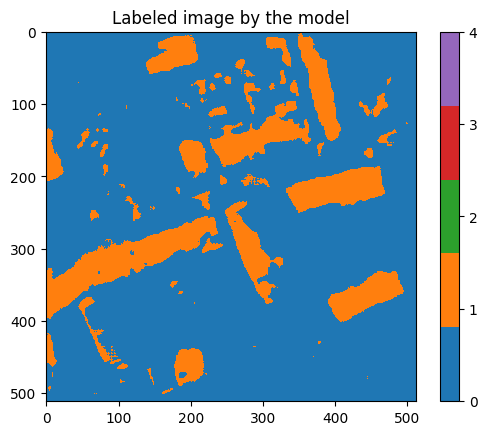



############# true label ################


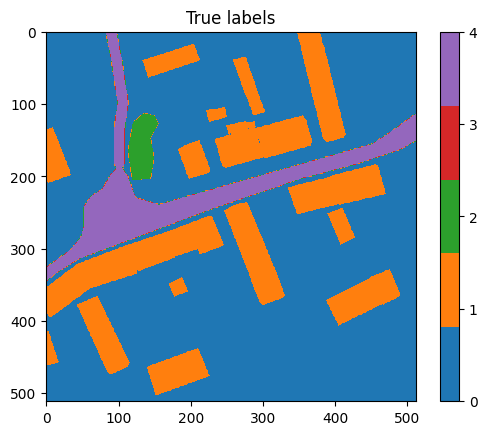

In [53]:
show_results_1_image(outputs2, lbl_array)

## Unet 3

In [61]:
class UNet3(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3, self).__init__()

        self.simple = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
        )
        # Encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Bottleneck (no pooling in the middle)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        # Décodeur
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        # Encodeur
        #x = self.encoder(x)

        # Bottleneck
        #x2 = self.bottleneck(x1)

        # Décodeur avec skip connection
        #x3 = self.decoder(x2)

        return self.simple(x)

In [62]:
outputs3 = train_1_image(UNet3,200)

input_data shape: torch.Size([1, 3, 512, 512])
label_data shape: torch.Size([1, 5, 512, 512])


100%|██████████| 200/200 [01:34<00:00,  2.11it/s]


############# result of the model ################


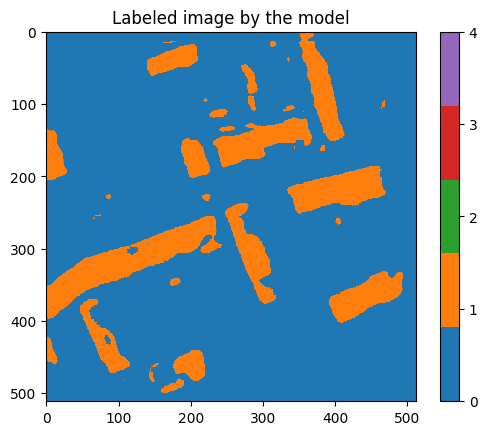



############# true label ################


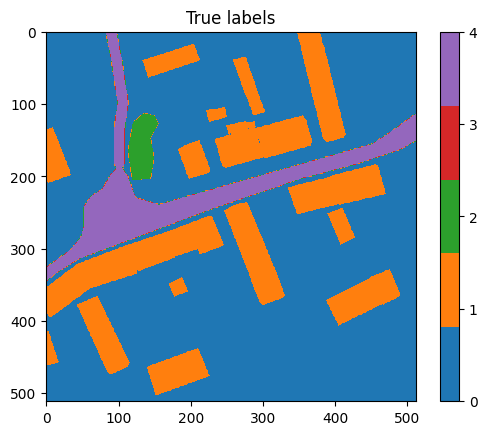

In [63]:
show_results_1_image(outputs3, lbl_array)